In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Positive, Interval

from alfi.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from alfi.utilities.torch import inv_softplus, softplus
from alfi.datasets import DeterministicLotkaVolterra
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.configuration import VariationalConfiguration
from alfi.trainers import VariationalTrainer

import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Num training points:  13


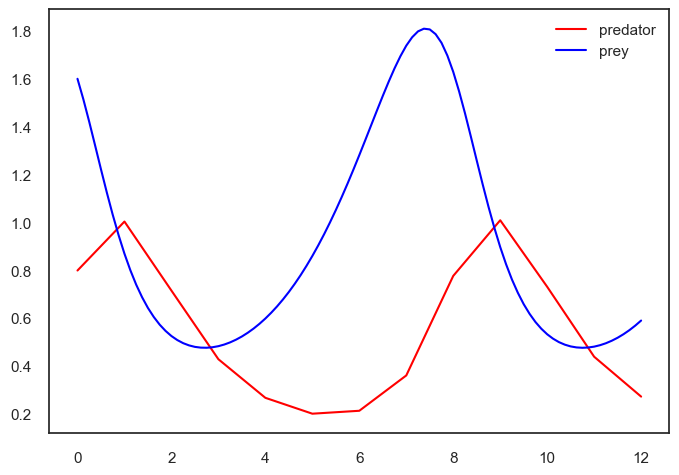

In [3]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=0.8,
)
x_min, x_max = min(dataset.times), max(dataset.times)
plt.rcParams['font.family'] = 'Arial'
plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]
num_inducing = 20

print('Num training points: ', num_training)
output_names = np.array(['pred','prey'])

In [3]:
dataset.data

[(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
  tensor([0.8000, 1.0043, 0.7162, 0.4298, 0.2687, 0.2025, 0.2147, 0.3621, 0.7775,
          1.0097, 0.7320, 0.4402, 0.2738], dtype=torch.float64))]

In [23]:
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 1.5)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        print(dataset.prey[::3].shape)
        self.true_f = dataset.prey[::3].unsqueeze(0).repeat(self.config.num_samples, 1).unsqueeze(1)
        print(self.true_f.shape)
    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
    
        f = self.f[:, :, self.t_index].unsqueeze(2)
        dh = self.growth_rate * h * f - self.decay_rate * h
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
    
        return dh

    def G(self, f):
        return softplus(f).repeat(1, self.num_outputs, 1)


tensor([[[0.6931]]], grad_fn=<SoftplusBackward>)
torch.Size([33])
torch.Size([70, 1, 33])


/Users/eirikbaekkelund/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/alfi/models/variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


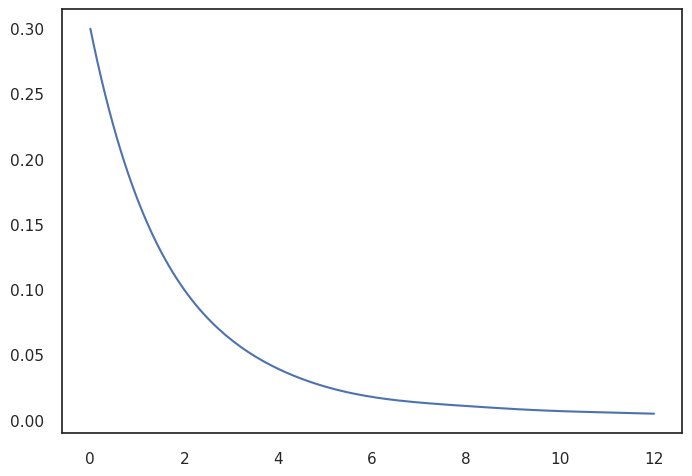

In [5]:
use_natural = False
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(
    num_latents, num_inducing, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))

track_parameters = ['raw_growth', 'raw_decay']

covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
    batch_shape=torch.Size([num_latents])
)  

covar_module.base_kernel.lengthscale = 3
covar_module.base_kernel.period_length = 8
track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')
track_parameters.append('gp_model.covar_module.base_kernel.raw_period_length')

gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, num_latents,
                         natural=use_natural)

lfm = LotkaVolterra(num_outputs, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))

out = lfm(t_predict, step_size=1e-2)
plt.plot(t_predict, out.mean.detach())


In [7]:
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=50,
    track_parameters=track_parameters
)

In [8]:
a = trainer.train(1000, report_interval=10, step_size=1/3)


Epoch 001/1000 - Loss: 1.20 (1.20 0.00) kernel: [3.019011]
Epoch 011/1000 - Loss: 1.14 (1.14 0.00) kernel: [2.9898503]
Epoch 021/1000 - Loss: 1.08 (1.08 0.00) kernel: [2.9568224]
Epoch 031/1000 - Loss: 1.03 (1.02 0.00) kernel: [2.9182436]
Epoch 041/1000 - Loss: 1.01 (0.99 0.03) kernel: [2.8634636]
Epoch 051/1000 - Loss: 0.97 (0.94 0.02) kernel: [2.8422544]
Epoch 061/1000 - Loss: 0.93 (0.91 0.02) kernel: [2.8341584]
Epoch 071/1000 - Loss: 0.89 (0.87 0.02) kernel: [2.83114]
Epoch 081/1000 - Loss: 0.86 (0.84 0.01) kernel: [2.8300939]
Epoch 091/1000 - Loss: 0.83 (0.82 0.01) kernel: [2.8297718]
Epoch 101/1000 - Loss: 0.82 (0.81 0.01) kernel: [2.8297665]
Epoch 111/1000 - Loss: 0.80 (0.79 0.01) kernel: [2.829877]
Epoch 121/1000 - Loss: 0.79 (0.78 0.01) kernel: [2.830154]
Epoch 131/1000 - Loss: 0.77 (0.76 0.01) kernel: [2.8304136]
Epoch 141/1000 - Loss: 0.75 (0.75 0.01) kernel: [2.8307407]
Epoch 151/1000 - Loss: 0.73 (0.73 0.00) kernel: [2.8310547]
Epoch 161/1000 - Loss: 0.73 (0.73 0.00) kerne

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


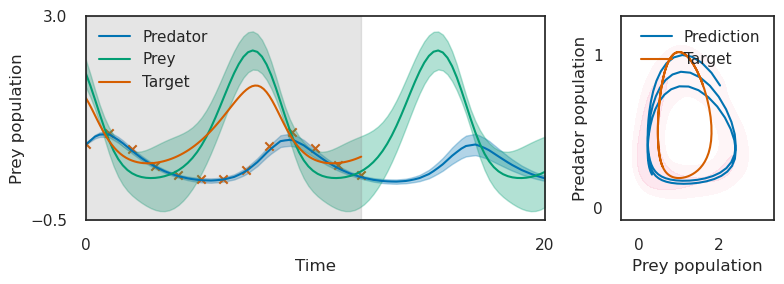

In [9]:
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=5e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.5, 3)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].plot(dataset.times, dataset.prey, c=Colours.scatter_color, label='Target')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[1])
axes[1].set_xlabel('Prey population')
axes[1].set_ylabel('Predator population')
axes[1].set_yticks([0, 1])
plt.tight_layout()
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
